In [17]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import pickle
from PIL import Image
import cv2

%matplotlib inline

### Baseline CNN model 

In [31]:
class Wildfire_CNN(nn.Module):
    def __init__(self):
        super(Wildfire_CNN, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout with a 50% drop probability
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [44]:
class ConditionalImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, conditional_offset=5):
        self.data_dir = data_dir
        self.transform = transform
        self.conditional_offset = conditional_offset
        self.data = []
        self._load_data()

    def _load_data(self):
        files = sorted([os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith('.mpy')])
        for file in files:
            with open(file, 'rb') as f:
                images = pickle.load(f)
                if isinstance(images, list):
                    images = np.array(images)
                self.data.append(images)

    def __len__(self):
        return sum(len(images) for images in self.data) - len(self.data) * self.conditional_offset

    def __getitem__(self, idx):
        collection_idx, image_idx = self._get_indices(idx)
        image = self.data[collection_idx][image_idx]
        cond_image = self.data[collection_idx][image_idx - self.conditional_offset]

        if self.transform:
            image = self.transform(image)
            cond_image = self.transform(cond_image)

        return image, cond_image

    def _get_indices(self, idx):
        cumulative_length = 0
        for collection_idx, images in enumerate(self.data):
            collection_length = len(images) - self.conditional_offset
            if idx < cumulative_length + collection_length:
                return collection_idx, idx - cumulative_length + self.conditional_offset
            cumulative_length += collection_length
        raise IndexError(f"Index {idx} out of range")
    
    
class WeightedMSELoss(nn.Module):
    def __init__(self, weight):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight
    
    def forward(self, output, target):
        mask = (target > 0).float()  # Mask for non-zero pixel values
        weighted_loss = self.weight * F.mse_loss(output * mask, target * mask, reduction='mean') + \
                        (1 - self.weight) * F.mse_loss(output * (1 - mask), target * (1 - mask), reduction='mean')
        return weighted_loss

In [48]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])

DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/bin_frames"

# MNIST DATA
dataset = ConditionalImageDataset(DATA_DIR, transform=transform)

# Split dataset into training and testing
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Wildfire_CNN()
model.to(device)

# Define loss function and optimizer
# Define the weight for the non-blank areas
weight = 0.9 # You can adjust this value

# Use this loss function during training
criterion = WeightedMSELoss(weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [49]:
def train(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for targets, inputs in dataloader:
            optimizer.zero_grad()
            
            targets = targets.float().to(device)
            inputs = inputs.float().to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

In [50]:
train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.022752662122781788
Epoch [2/10], Loss: 0.019579971697004067
Epoch [3/10], Loss: 0.019458925174105735
Epoch [4/10], Loss: 0.01950284922938971
Epoch [5/10], Loss: 0.019631149823821727
Epoch [6/10], Loss: 0.019526188793991293
Epoch [7/10], Loss: 0.019639343466787113
Epoch [8/10], Loss: 0.019584702726985728
Epoch [9/10], Loss: 0.019532192232353345
Epoch [10/10], Loss: 0.019530683312387692


In [51]:
# Function to calculate MSE and SSIM
def calculate_metrics(output, target):
    output_np = output.squeeze().detach().cpu().numpy()
    target_np = target.squeeze().detach().cpu().numpy()
    
    mse_value = np.mean((output_np - target_np) ** 2)
    ssim_value = ssim(output_np, target_np, data_range=target_np.max() - target_np.min())
    
    return mse_value, ssim_value

# Inference function
def evaluate_model(model, dataloader):
    model.eval()
    total_mse = 0.0
    total_ssim = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for targets, inputs in dataloader:
            targets = targets.float().to(device)
            inputs = inputs.float().to(device)
            
            outputs = model(inputs)
            
            mse, ssim_val = calculate_metrics(outputs, targets)
            total_mse += mse * inputs.size(0)
            total_ssim += ssim_val * inputs.size(0)
            num_samples += inputs.size(0)
    
    avg_mse = total_mse / num_samples
    avg_ssim = total_ssim / num_samples
    
    print(f"Average MSE: {avg_mse:.4f}, Average SSIM: {avg_ssim:.4f}")

In [52]:
evaluate_model(model, test_loader)

Average MSE: 0.0259, Average SSIM: 0.7577


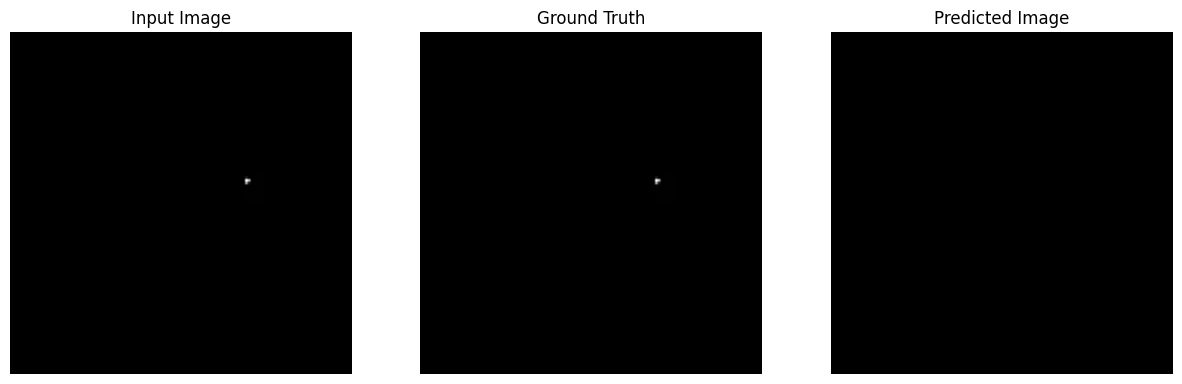

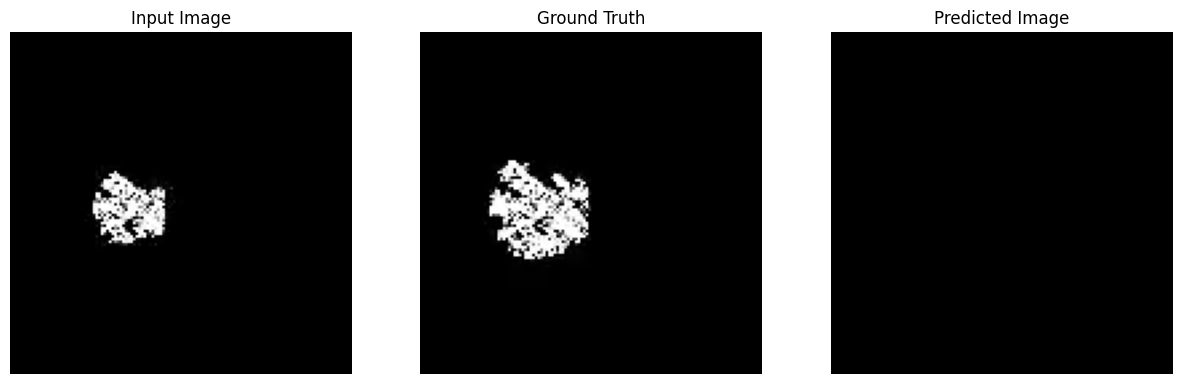

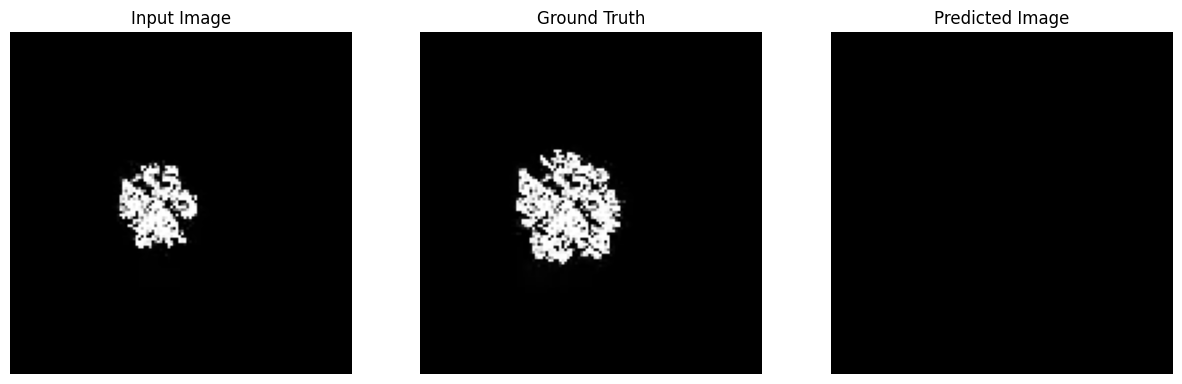

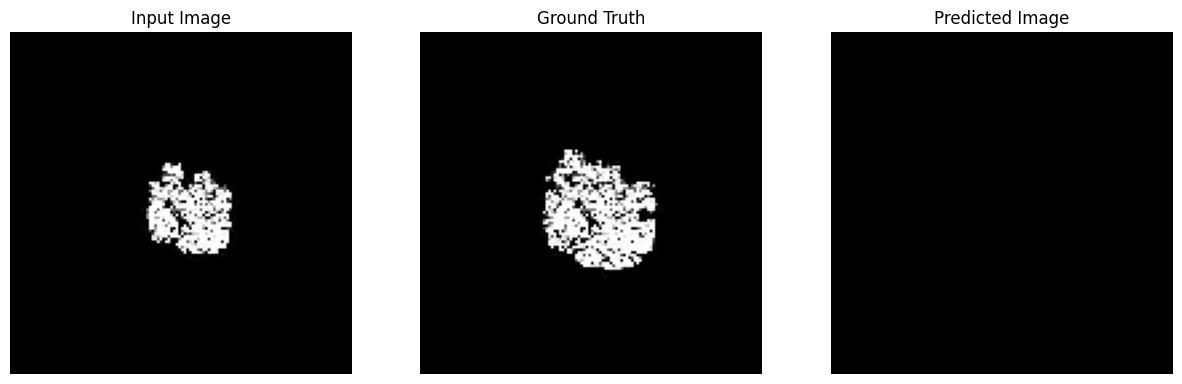

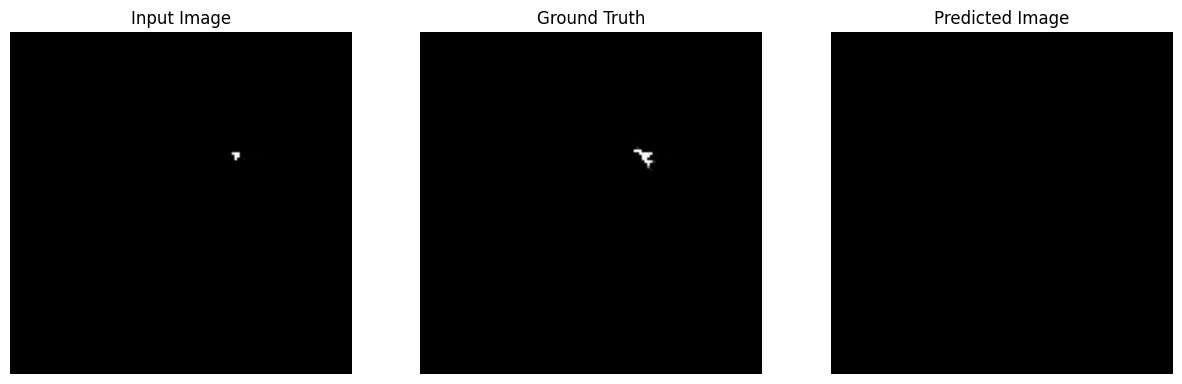

In [53]:
# Define the visualization function
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images_shown = 0
    
    with torch.no_grad():
        for targets, inputs in dataloader:
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            
            outputs = model(inputs)
            
            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break
                
                input_image = inputs[i].squeeze().cpu().numpy()
                target_image = targets[i].squeeze().cpu().numpy()
                output_image = outputs[i].squeeze().cpu().numpy()
                
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(input_image, cmap='gray')
                axes[0].set_title('Input Image')
                axes[0].axis('off')
                
                axes[1].imshow(target_image, cmap='gray')
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')
                
                axes[2].imshow(output_image, cmap='gray')
                axes[2].set_title('Predicted Image')
                axes[2].axis('off')
                
                plt.show()
                
                images_shown += 1
            
            if images_shown >= num_images:
                break

visualize_predictions(model, test_loader, num_images=5)